## Creating ML Models

### Importing required libraries

In [298]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
from sklearn import datasets
from sklearn.model_selection import train_test_split  
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import copy
from sklearn.linear_model import LogisticRegression
import os
import difflib
import math
import re
import time
from datetime import timedelta

### Specifying year to run Modeling on and Files to Import

In [299]:
year_to_perform_modeling  = "2015"
csv = r'C:\Users\Public\Modeling\modeling_%s.csv' %year_to_perform_modeling
df_modeling = pd.read_csv(csv)
df_modeling = df_modeling.drop(['Unnamed: 0'],axis=1)
df_modeling = df_modeling.drop_duplicates()
df_modeling['DateTime'] = pd.to_datetime(df_modeling['Date'], format='%Y-%m-%d')

### Function to create exponentially time weighting data

In [300]:
def generateWeightFactors(df,B=2):
    delta = (df['DateTime'].iloc[-1] - df['DateTime']).dt.days
    weight_factor = np.exp(-B*delta)
    weight_factor = weight_factor.to_numpy()
    weight_factor = weight_factor.reshape(weight_factor.shape[0],1)
    return weight_factor   

### Function to create Testing Dataframe
<b><u> Note: </u></b> The purpose of this is to make sure that there is only data availabe prior to the day to predict for included in testing data.
- So, for the ERA and Batting averges are filled using most recent previous score
- The plate appearnce is an estimated average using formula found online
- The Batter line up position is published before game day

In [301]:
def createTestingDataFrame(X_test_unprocessed, X_train):
    X_test = X_test_unprocessed.drop(['Number_Of_Plate_Appearances', 'Batting_Average', 'ERA'], axis =1)
        
    # Filling in PA with estimations from website cited in report
    dict_avg_appr ={1:4.65,
            2:4.55,
            3:4.43,
            4: 4.33,
            5:4.24,
             6:4.13,
             7:4.01,
             8:3.90,
             9:3.77}
    
    X_test["Number_Of_Plate_Appearances"] = X_test["Position_In_Lineup"].map(dict_avg_appr)

    # Filling in BA for specific player with their most recent previous game BA
    batting_average_in_order_of_player = []
    for i, player in enumerate(X_test['Batter']):
        batting_average_temp_df = X_train[X_train["Batter"] == player]["Batting_Average"]
        if batting_average_temp_df.empty:
            batting_average_temp = np.nan
        else:
            batting_average_temp = batting_average_temp_df.iloc[-1]            
        
        batting_average_in_order_of_player.append(batting_average_temp)
            
    X_test["Batting_Average"] = batting_average_in_order_of_player
    
    # Filling in ERA for specific pitcher with their most recent previous game ERA    
    era_in_order_of_player = []
    for j, pitcher in enumerate(X_test['Pitcher']):
        era_temp_df = X_train[X_train["Pitcher"] == pitcher]['ERA']
        if era_temp_df.empty:
            era = np.nan
        else:
            era = era_temp_df.iloc[-1]            
        
        era_in_order_of_player.append(era)
            
    X_test["ERA"] = era_in_order_of_player
    
    # Remove any rows containing nan and get their index     
    index_ba = X_test['Batting_Average'].index[X_test['Batting_Average'].apply(np.isnan)]
    index_era = X_test['ERA'].index[X_test['ERA'].apply(np.isnan)]
    index_pa = X_test['Number_Of_Plate_Appearances'].index[X_test['Number_Of_Plate_Appearances'].apply(np.isnan)]

    # Combine index using sets to remove duplicates   
    index = list(set(index_ba.to_list() + index_era.to_list()+ index_pa.to_list()))
    
        
    X_test = X_test.dropna()
    return X_test, index

## Modeling Functions
<b><u> Note:</u></b> This section contains variations of logistic regression modeling. <br>
The modeling changes include:
- Number of parameters used for modeling 
- Expontial time weighting data
- Limiting the number of previous days to be considered for training data

### Function to create models with varying number of factors to include
<b><u> Note: </u></b> The purpose of this function is to determine how many relevant factors (based on heat map relevancy rating) need to be included before the model is overfitted
- The main way this is determined is through visual inspection of output plots
- However, another way is through using logistic regression accuracy training and testing accuracy score results

In [302]:
def createModelVaryingFactorsToInclude (date_range_to_predict, df_modeling, factors_to_include):
    predict_output =[]
    predict_probability = []
    expected_output =[]
    batter_predicted_for = []

    counter = (date_range_to_predict[0] - df_modeling['DateTime'][0]).days - 1
    num_of_days = []
    
    for date in date_range_to_predict:
        df_specific = copy.deepcopy(df_modeling)[df_modeling['DateTime'] <= date]

        X_train = df_specific[df_specific['DateTime']< date][factors_to_include]
        
        X_test_unprocessed = df_specific[df_specific['DateTime'] == date][factors_to_include]
        
        if X_test_unprocessed.empty:
            continue
        
        X_test, index = createTestingDataFrame(X_test_unprocessed, X_train)
        
    

        y_train = df_specific[df_specific['DateTime']< date][['Hit']]
        y_test = df_specific[df_specific['DateTime']== date][['Hit']]
        y_test = y_test.drop(index)

        log_reg = LogisticRegression( max_iter = 500)
        log_reg.fit(X_train, y_train.values.ravel())
        y_pred = log_reg.predict(X_test)
        y_prob = log_reg.predict_proba(X_test)
        
        batter_predicted_for.append(X_test['Batter'].to_list())
        predict_output.append(y_pred)
        predict_probability.append(y_prob)
        expected_output.append(y_test['Hit'].to_list())
        num_of_days.append(counter)
        counter += 1
        
    return predict_output, predict_probability, expected_output, batter_predicted_for, num_of_days


### Function to create  models with varying weights
<b><u> Note: </u></b> This is implemented by exponentially time weighting the training data with respect to the date to predict for

In [303]:
def createModelVaryingWeights (date_range_to_predict, df_modeling, weight_factor_B, factors_to_include):
    predict_output =[]
    predict_probability = []
    expected_output =[]
    batter_predicted_for = []

    counter = (date_range_to_predict[0] - df_modeling['DateTime'][0]).days - 1
    num_of_days = []
    for date in date_range_to_predict:
        df_specific = copy.deepcopy(df_modeling)[df_modeling['DateTime'] <= date]
        weight_df = copy.deepcopy(df_modeling)[df_modeling['DateTime'] < date]
        weight = generateWeightFactors(weight_df, weight_factor_B)

        X_train = df_specific[df_specific['DateTime']< date][factors_to_include]
        X_test_unprocessed = df_specific[df_specific['DateTime'] == date][factors_to_include]
        
        if X_test_unprocessed.empty:
            continue
        
        X_test, index = createTestingDataFrame(X_test_unprocessed, X_train)

        y_train = df_specific[df_specific['DateTime']< date][['Hit']]
        y_test = df_specific[df_specific['DateTime']== date][['Hit']]
        y_test = y_test.drop(index)


        log_reg = LogisticRegression( max_iter = 500)
        log_reg.fit(X_train, y_train.values.ravel(), sample_weight = weight.ravel())
        y_pred = log_reg.predict(X_test)
        y_prob = log_reg.predict_proba(X_test)
        
        batter_predicted_for.append(X_test['Batter'].to_list())
        predict_output.append(y_pred)
        predict_probability.append(y_prob)
        expected_output.append(y_test['Hit'].to_list())
        num_of_days.append(counter)
        counter += 1
        
    return predict_output, predict_probability, expected_output, batter_predicted_for, num_of_days


### Function to create models with varying training data size
<b><u> Note: </u></b> This is implemented by specifying how many prior days before the day to predict for needs to be used in training model

In [304]:
def createModelWithFixedTrainingBlockSize (date_range_to_predict, df_modeling, factors_to_include, numberOfDaysInTraining = 90):
    predict_output =[]
    predict_probability = []
    expected_output =[]
    batter_predicted_for = []

    counter = (date_range_to_predict[0] - df_modeling['DateTime'][0]).days - 1
    num_of_days = []
    test_size_List = []
    for date in date_range_to_predict:
        df_specific = copy.deepcopy(df_modeling)[df_modeling['DateTime'] <= date]
        if (date - df_specific['DateTime'][0]).days > numberOfDaysInTraining: 
            df_specific = df_specific[df_specific['DateTime'] >= (date - timedelta(days=numberOfDaysInTraining)) ]

        X_train = df_specific[df_specific['DateTime']< date][factors_to_include]
        test_size_List.append(X_train.shape) 

        X_test_unprocessed = df_specific[df_specific['DateTime'] == date][factors_to_include]
        counter += 1
        if X_test_unprocessed.empty:
            continue
        
        X_test, index = createTestingDataFrame(X_test_unprocessed, X_train)
        
        y_train = df_specific[df_specific['DateTime']< date][['Hit']]
        y_test = df_specific[df_specific['DateTime']== date][['Hit']]
        y_test = y_test.drop(index)


        log_reg = LogisticRegression( max_iter = 500)
        log_reg.fit(X_train, y_train.values.ravel())
        y_pred = log_reg.predict(X_test)
        y_prob = log_reg.predict_proba(X_test)
        
        batter_predicted_for.append(X_test['Batter'].to_list())
        predict_output.append(y_pred)
        predict_probability.append(y_prob)
        expected_output.append(y_test['Hit'].to_list())
        num_of_days.append(counter)
        
    return predict_output, predict_probability, expected_output, batter_predicted_for, num_of_days


### Function to convert logistic regression testing probabilty predictions to Hit/No Hit
<b><u> Note: </u></b> The function takes the hit proabality predictions and convert it to hit or no hit based on specifeid threshold.


In [305]:
def convertProbabilityToPredictionBasedOnThreshold(predict_probability, threshold = 0.6):
    converted_predictions = []
    for element in predict_probability:
        for_specific_date_predictions = element[:,1]
        for_specific_date_predictions[for_specific_date_predictions < threshold] = 0
        for_specific_date_predictions[for_specific_date_predictions >= threshold] = 1
        converted_predictions.append(for_specific_date_predictions)
    
    return converted_predictions
   

## Model Accuracy Checkers

### Function to check the overall accuracy of logistic regression predictions
 The accuracy is classified into three types:
 - Correct prediction: if model accurately predcits hit or no hit
 - Acceptable prediction: if the model predicts a no hit for expedcted hit case
 - Not Acceptable prediction: if the model predics a hit when in reality it was no hit

In [306]:
def preditcAccuracy(expected_outcome, predicted_outcome):

    percent_for_output_types = []

    for i in range(len(predicted_outcome)):
        total_predictions = len(predicted_outcome[i])
        output_difference = predicted_outcome[i] - expected_outcome[i]

        output_acceptable = np.count_nonzero(output_difference == -1)/total_predictions *100 # predicted - expected = -1
        out_not_acceptable = np.count_nonzero(output_difference == 1)/total_predictions *100 # predicted - expected = 1
        correct_output = np.count_nonzero(output_difference == 0)/total_predictions *100 # predicted = expected 
        percent_for_output_types.append([output_acceptable, out_not_acceptable, correct_output])
   
    return percent_for_output_types


### Function to check accuracy of hits predicted
<b><u> Notes:</u></b> 
- Unlike the precious accuracy checker this function only indicates the number of correct hit predictions compared to acceptable and not accpetable predictions
- The correct no hit predictions are not displayed in the plots 

In [307]:
def probabilityOfAccuratelyPredictingHit(expected_outcome, predicted_outcome):

    percent_for_output_types = []

    for i in range(len(predicted_outcome)):
        total_predictions = len(predicted_outcome[i])
        factor_to_differentiate = 2
        output_difference = predicted_outcome[i]*factor_to_differentiate - expected_outcome[i]

        output_acceptable = np.count_nonzero(output_difference == -1)/total_predictions *100 # predict_no_hit - expected_hit = -1
        out_not_acceptable = np.count_nonzero(output_difference == 2)/total_predictions *100 # predict_hit - expected_no_hit = 2
        #correct_output_no_hit = np.count_nonzero(output_difference == 0)/total_predictions *100 # predict_no_hit = expect_no_hit
        correct_output_hit =  np.count_nonzero(output_difference == 1)/total_predictions *100 # predict_hit - expected_hit = 1
        percent_for_output_types.append([output_acceptable, out_not_acceptable, correct_output_hit])
   
    return percent_for_output_types


In [308]:
def comapringCorrectAndWrongHitPredictionNumbers(expected_outcome, predicted_outcome):

    percent_for_output_types = []
    num_of_day = 30
    num_of_days = []

    for i in range(len(predicted_outcome)):
        factor_to_differentiate = 2
        output_difference = predicted_outcome[i]*factor_to_differentiate - expected_outcome[i]
        
        total_hit_predictions = np.count_nonzero(predicted_outcome[i] == 1)
        if (total_hit_predictions == 0):
            continue

        out_not_correct_hit_prediction = np.count_nonzero(output_difference == 2)/total_hit_predictions *100 # predict_hit - expected_no_hit = 2
        out_correct_hit_prediction =  np.count_nonzero(output_difference == 1)/total_hit_predictions *100 # predict_hit - expected_hit = 1
        percent_for_output_types.append([out_correct_hit_prediction, out_not_correct_hit_prediction])
        num_of_days.append(num_of_day+i)
   
    return percent_for_output_types, num_of_days


## Plotting Functions to Assess Effectivness of Models 

### Function to plot each modeling case result on single plot 

In [309]:
def createSingleCasePredictionPlot(percent_for_output_types, plot_name, num_of_days):
    negative_output, positive_output,correct_output = map(list, zip(*percent_for_output_types))
    plt.figure()
    plt.plot(num_of_days, negative_output, label = 'Acceptable')
    plt.plot(num_of_days, positive_output, label= 'Not acceptable')
    plt.plot(num_of_days, correct_output, label = 'Correct')
    plt.legend()
    plt.xlabel('Dates', fontsize=13)
    plt.ylabel('% Predictions', fontsize=13)
    plt.title('Comparing Correct Hit Prediction Percent' , fontsize =15)
    plt.savefig(r'C:\Users\Public\Project Output Plots\%s.jpeg' %plot_name, bbox_inches='tight',dpi=1000)


### Function to plot each modeling case accuracy result on single plot 

In [310]:
def createSingleCaseCorrectHitPercentPlot(percent_for_output_types, plot_name, num_of_days):
    correct_output, wrong_output = map(list, zip(*percent_for_output_types))
    plt.figure()
    plt.plot(num_of_days, correct_output, label = 'Correct  Hit Prediction')
    plt.plot(num_of_days, wrong_output, label= 'Wrong Hit Prediction')
    plt.legend()
    plt.xlabel('Dates', fontsize=13)
    plt.ylabel('% Hit Predictions', fontsize=13)
    plt.title('Correct Vs. Wrong Prediction Percent' , fontsize =15)
    plt.savefig(r'C:\Users\Public\Project Output Plots\%s.jpeg' %plot_name, bbox_inches='tight',dpi=1000)

### Function to plot all accuracy cases for all modeling result on one plot 
<b><u> Note:</u></b> While this does say all modeling, it means all cases for a variation of modeling. For ex: all weighting criteria for weighting data model prediction will be on one plot. 

In [311]:
def createComparativePlot(list_percent_for_output_types, list_of_comparer, plot_name,number_of_days_list):
    color_list = ['k','r','g','b']
    line_type = ['-','--',':','-.']
    
    plt.figure()
    for i,simulation in enumerate(list_percent_for_output_types):
        negative_output, positive_output,correct_output = map(list, zip(*simulation))
        plt.plot(number_of_days_list[i], negative_output,linestyle=line_type[0],color=color_list[i] ,label = list_of_comparer[i]+' Acceptable')
        plt.plot(number_of_days_list[i], positive_output,linestyle=line_type[1],color=color_list[i], label= list_of_comparer[i]+' Not acceptable')
        plt.plot(number_of_days_list[i], correct_output, linestyle=line_type[2],color=color_list[i], label = list_of_comparer[i]+' Correct')
        plt.legend()
        plt.xlabel('Dates', fontsize=13)
        plt.ylabel('% Predictions', fontsize=13)
        plt.savefig(r'C:\Users\Public\Project Output Plots\%s.jpeg' %plot_name, bbox_inches='tight',dpi=1000)
        

### Function to plot a specific accuracy case for all modeling result on single plot
<b> <u> Note:</u></b> This means there will be three plots in total for each variation case:
- correct accuracy for all cases 
- not acceptable accuracy for all case
- acceptable accuracy for all cases 

In [312]:
def createComparativeSeprate(list_percent_for_output_types, list_of_comparer,number_of_days_list, compare_name):
    color_list = ['k','r','g','b']
    line_type = ['-','--',':','-.']
   
    plt.figure()
    for i,simulation in enumerate(list_percent_for_output_types):
        negative_output, positive_output,correct_output = map(list, zip(*simulation))
        plt.plot(number_of_days_list[i], negative_output,linestyle=line_type[0],color=color_list[i] ,label = list_of_comparer[i]+' Acceptable')
        plt.legend()
        plt.xlabel('Dates', fontsize=13)
        plt.ylabel('%', fontsize=13)
        plt.savefig(r'C:\Users\Public\Project Output Plots\acceptableValues_%s.jpeg' %compare_name, bbox_inches='tight',dpi=1000)
    
    plt.figure()
    for i,simulation in enumerate(list_percent_for_output_types):
        negative_output, positive_output,correct_output = map(list, zip(*simulation))
        plt.plot(number_of_days_list[i], positive_output,linestyle=line_type[1],color=color_list[i], label= list_of_comparer[i]+' Not acceptable')
        plt.legend()
        plt.xlabel('Dates', fontsize=13)
        plt.ylabel('%', fontsize=13)
        plt.savefig(r'C:\Users\Public\Project Output Plots\notAcceptableValues_%s.jpeg' %compare_name, bbox_inches='tight',dpi=1000)
    
    plt.figure()
    for i,simulation in enumerate(list_percent_for_output_types):
        negative_output, positive_output,correct_output = map(list, zip(*simulation))
        plt.plot(number_of_days_list[i], correct_output, linestyle=line_type[2],color=color_list[i], label = list_of_comparer[i]+' Correct')
        plt.legend()
        plt.xlabel('Dates', fontsize=13)
        plt.ylabel('%', fontsize=13)
        plt.savefig(r'C:\Users\Public\Project Output Plots\correctValues_%s.jpeg' %compare_name, bbox_inches='tight',dpi=1000)
        

## Running Model Variations 
<b><u> Note: </u></b> The purpose of this section is to run all the modeling variation and choose the best modeling or combination to play "Beat the Streak" for 5 different MLB seasons

### Modeling to choose number of factors to include

Done with number of factors = ['Batter', 'Position_In_Lineup', 'Pitcher', 'Batting_Average', 'ERA', 'Number_Of_Plate_Appearances']
Done with number of factors = ['Batter', 'Position_In_Lineup', 'Pitcher', 'Batting_Average', 'ERA', 'Number_Of_Plate_Appearances', 'Difference_Batter_And_Pitcher']


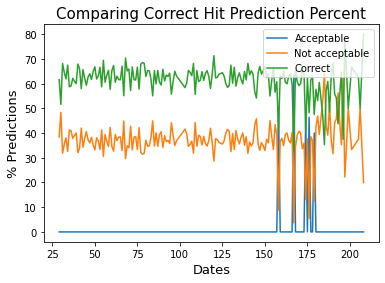

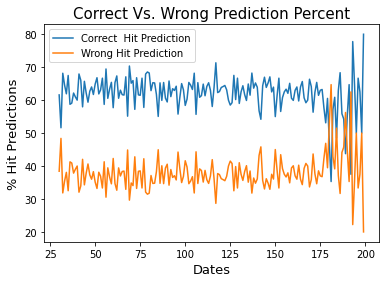

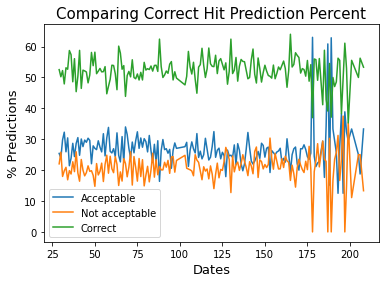

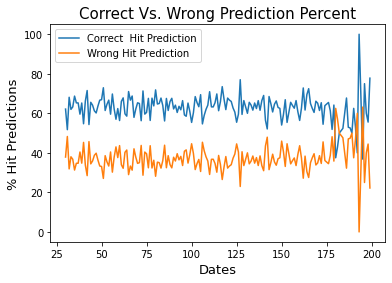

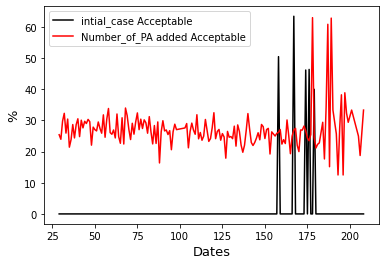

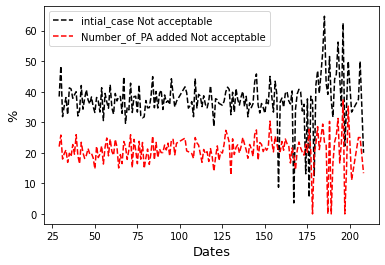

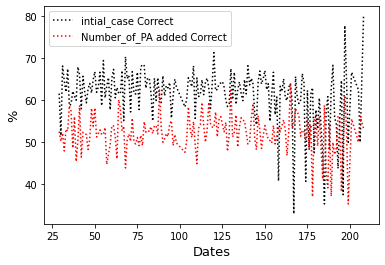

In [297]:
date_range_to_predict = pd.date_range(start="2015-05-04",end="2015-10-30")
df_modeling = copy.deepcopy(df_modeling)[['Batter', 'Position_In_Lineup', 'Pitcher', 'Number_Of_Plate_Appearances','Batting_Average','ERA', 'Difference_Batter_And_Pitcher', 'DateTime', 'Hit']]

factors_to_include_list = [['Batter', 'Position_In_Lineup', 'Pitcher', 'Batting_Average','ERA', 'Number_Of_Plate_Appearances'],
                           ['Batter', 'Position_In_Lineup', 'Pitcher', 'Batting_Average','ERA', 'Number_Of_Plate_Appearances','Difference_Batter_And_Pitcher']]

list_of_comparer = ['intial_case', 'Number_of_PA added', 'Difference_Batter_And_Pitcher_Hand']

list_percent_for_output_types = []
list_percent_for_correct_hit = []
number_of_days_list = []

i = 0
for factors_to_include in factors_to_include_list:
    predict_output, predict_probability, expected_output, batter_predicted_for, num_of_days =  createModelWithFixedTrainingBlockSize(date_range_to_predict,df_modeling, factors_to_include)
    converted_predictions = convertProbabilityToPredictionBasedOnThreshold(predict_probability, threshold = 0.8)
    percent_for_output_types = preditcAccuracy(expected_output, converted_predictions)
    
    list_percent_for_output_types.append(percent_for_output_types)
    number_of_days_list.append(num_of_days)
    createModelVaryingFactorsToInclude
    percent_for_correct_hit, num_of_days_2 = comapringCorrectAndWrongHitPredictionNumbers(expected_output, converted_predictions)
    list_percent_for_correct_hit.append(percent_for_correct_hit)
    
    createSingleCasePredictionPlot(percent_for_output_types, 'NumberOfFactors_' + list_of_comparer[i], num_of_days)
    createSingleCaseCorrectHitPercentPlot(percent_for_correct_hit, 'correct_number_of_factor_included_' + list_of_comparer[i], num_of_days_2)

    
    print("Done with number of factors = " + str(factors_to_include))
    
    i+=1

createComparativeSeprate(list_percent_for_output_types, list_of_comparer,number_of_days_list, "Varying Number of Factor")



### Modeling variable training blocking 

In [ ]:
date_range_to_predict = pd.date_range(start="2015-05-04",end="2015-10-30")

df_modeling = copy.deepcopy(df_modeling)[['Batter', 'Position_In_Lineup', 'Pitcher', 'Number_Of_Plate_Appearances','Batting_Average','ERA', 'Difference_Batter_And_Pitcher', 'DateTime', 'Hit']]
factors_to_include_list = ['Batter', 'Pitcher','Position_In_Lineup', 'Number_Of_Plate_Appearances', 'Batting_Average', 'ERA']

number_of_training_days_List = [200, 90, 60, 30]
list_of_comparer = ['All Days Included', '90 Days Included', '60 Days Included', '30 Days Included']


list_percent_for_output_types = []
list_percent_for_correct_hit = []
number_of_days_list = []


for number_of_training_days in number_of_training_days_List:
    predict_output, predict_probability, expected_output, batter_predicted_for, num_of_days = createModelWithFixedTrainingBlockSize(date_range_to_predict,
                                                                                                                                    df_modeling, 
                                                                                                                                    factors_to_include_list,
                                                                                                                                    number_of_training_days)
    converted_predictions = convertProbabilityToPredictionBasedOnThreshold(predict_probability, threshold = 0.8)
    percent_for_output_types = preditcAccuracy(expected_output, converted_predictions)
    list_percent_for_output_types.append(percent_for_output_types)
    
    percent_for_correct_hit, num_of_days_2 = comapringCorrectAndWrongHitPredictionNumbers(expected_output, converted_predictions)
    list_percent_for_correct_hit.append(percent_for_correct_hit)

    number_of_days_list.append(num_of_days)
    createSingleCasePredictionPlot(percent_for_output_types, 'traing_number_days_to_include_' + str(number_of_training_days), num_of_days)
    createSingleCaseCorrectHitPercentPlot(percent_for_correct_hit, 'correct_number_days_to_include_' + str(number_of_training_days), num_of_days_2)
    print("Done with block size = " + str(number_of_training_days))

#createComparativePlot(list_percent_for_output_types, list_of_comparer, "WeightVariable",number_of_days_list)
#createComparativeSeprate(list_percent_for_output_types, list_of_comparer,number_of_days_list, "Period Variable_all")


### Modeling with variable weights

In [ ]:
date_range_to_predict = pd.date_range(start="2015-05-04",end="2015-10-30")
df_modeling = copy.deepcopy(df_modeling)[['Batter', 'Position_In_Lineup', 'Pitcher', 'Number_Of_Plate_Appearances','Batting_Average','ERA', 'Difference_Batter_And_Pitcher', 'DateTime', 'Hit']]
factors_to_include_list = ['Batter', 'Pitcher','Position_In_Lineup', 'Number_Of_Plate_Appearances', 'Batting_Average', 'ERA']

weight_factor_B_list = [0,1,5,10]
list_of_comparer = ['Weight Factor of 0: ', 'Weight Factor of 1: ', 'Weight Factor of 5: ', 'Weight Factor of 10: ']

list_percent_for_output_types = []
list_percent_for_correct_hit = []
number_of_days_list = []

for weight in weight_factor_B_list:
    predict_output, predict_probability, expected_output, batter_predicted_for, num_of_days = createModelVaryingWeights (date_range_to_predict,
                                                                                                       df_modeling,
                                                                                                       weight,
                                                                                                       factors_to_include_list)
    converted_predictions = convertProbabilityToPredictionBasedOnThreshold(predict_probability, threshold = 0.8)
    percent_for_output_types = preditcAccuracy(expected_output, converted_predictions)
    list_percent_for_output_types.append(percent_for_output_types)
    number_of_days_list.append(num_of_days)
    
    percent_for_correct_hit, num_of_days_2 = comapringCorrectAndWrongHitPredictionNumbers(expected_output, converted_predictions)
    list_percent_for_correct_hit.append(percent_for_correct_hit)
    
    createSingleCasePredictionPlot(percent_for_output_types, 'weight_' + str(weight), num_of_days)
    createSingleCaseCorrectHitPercentPlot(percent_for_correct_hit, 'correct_weight_' + str(weight), num_of_days_2)
    
   
    
    print("Done with weight = " + str(weight))

#createComparativePlot(list_percent_for_output_types, list_of_comparer, "WeightVariable",number_of_days_list)
#createComparativeSeprate(list_percent_for_output_types, list_of_comparer,number_of_days_list, "WeightVariable")
    

Done with weight = 0
Done with weight = 1
Done with weight = 5
